Before this script can be executed, please follow the steps in /Data/C_Elegans/README.txt

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import random

import os
import colorsys
import imageio as io

from skimage.draw import line_aa,circle_perimeter,ellipse
from scipy.signal import convolve2d as convolve

In [2]:
num_samples = 750

In [3]:
data_path = '../Data/C_Elegans/'

In [4]:
images = []
for element in os.listdir(data_path + 'Original/'):
    if element[-4:] == ".png":
        im = io.imread(data_path + 'Original/' + element)
        if im.shape[0] != 430 or im.shape[1] != 430:
            image = np.zeros((430,430))
            image[:im.shape[0],:im.shape[1]] = im
        else:
            image = im
        images.append(image)
images = np.stack(images,0)

In [5]:
if len(images) != 97:
    raise Exception('Wrong length of data. Please make sure you followed the README.txt in the directory /Data/C_Elegans/')

## Approximate the background

In [6]:
med_im  = np.median(images.astype(np.double),axis=0)/255

gauss  = np.copy(med_im[50:-50,50:-50])
k      = np.log(gauss)

ls1   = np.linspace(-(430-100)/2.+0.5,(430-100)/2.-0.5,(430-100))
ls2   = np.linspace(-(430-100)/2.+0.5,(430-100)/2.-0.5,(430-100))
X, Y  = np.meshgrid(ls1, ls2)

R     = X**2 + Y**2

# converge k and R into vectors
k     = np.reshape(k,[-1])
R     = np.reshape(R,[-1, 1])

# Add an offset to R
R     = np.tile(R,[1,2])
R[:,1]= 1

# Get parameter
x,_,_,_ = np.linalg.lstsq(R,k)

# Create background
ls1   = np.linspace(-430/2.+0.5,430/2.-0.5,430)
ls2   = np.linspace(-430/2.+0.5,430/2.-0.5,430)
X, Y  = np.meshgrid(ls1, ls2)

R     = X**2 + Y**2

K     = x[1] + x[0] * R

bg    = np.exp(K)

mask         = np.zeros((430,430,3),dtype=np.double)
mask[:,:,2] += bg*((med_im>0.2).astype(np.double))

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


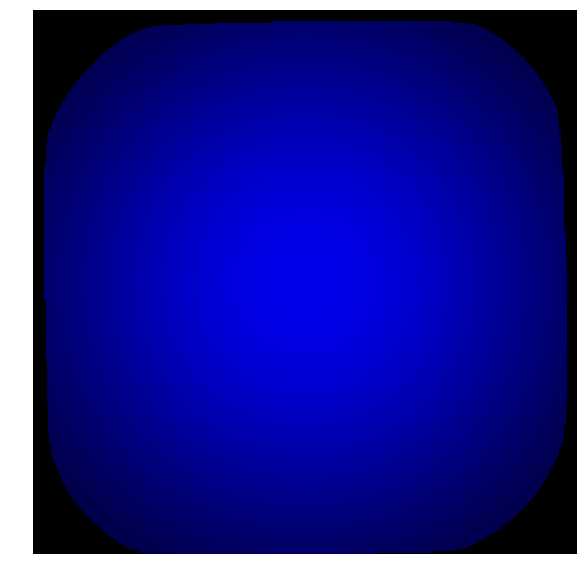

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(mask)
plt.axis('off')
plt.show()

## Create the images

In [8]:
def thickness(k,n):
    r = 1.*k/n
    if r>0.5:
        r = 1-r
    r = 1 - 0.5 * (1-r)**10 # multiply by this factor
    thickness = 3*r + np.random.randn()*0.5
    if thickness < 1:
        thickness = 1
    return int(thickness+0.5)

In [9]:
def draw_dead_worm(image,gt):
    n   = 20
    thr = 0.02 * np.pi
    vel = 0.01
    
    image_old = np.copy(image)
    gt_old    = np.copy(gt)
    
    for k in range(n):
        if k == 0:
            x_start  = int(np.random.random()*(image.shape[0]-40))+20
            y_start  = int(np.random.random()*(image.shape[0]-40))+20
            angle    = np.random.random()*2*np.pi
            angle_o  = np.random.randn()*vel/5.
        else:
            x_start  = x_stop
            y_start  = y_stop
            angle   += angle_o
            angle_o += np.random.randn()*vel*np.pi/10.
            if angle_o > thr:
                angle_o = thr
            elif angle_o < -thr:
                angle_o = -thr
        
        length  = 125./n + np.random.randn()*15/np.sqrt(n)
    
        x_stop  = int(x_start + np.cos(angle)*length)
        y_stop  = int(y_start + np.sin(angle)*length)
        
        if x_start == x_stop:
            x_stop += int(np.sign(np.random.randn()))
        if y_start == y_stop:
            y_stop += int(np.sign(np.random.randn()))

        x,y,_ = line_aa(x_start,y_start,x_stop,y_stop)
        X = []
        Y = []
        for i in range(len(x)):
            xx,yy = circle_perimeter(x[i],y[i],thickness(k,n))
            X.append(xx)
            Y.append(yy)
        x = np.concatenate(X)
        y = np.concatenate(Y)

        i1      = np.where(x>=0)
        i2      = np.where(y>=0)
        i3      = np.where(x<image.shape[0])
        i4      = np.where(y<image.shape[1])

        i       = np.intersect1d(np.intersect1d(i1,i2),np.intersect1d(i3,i4))
        x       = x[i]
        y       = y[i]        
        i       = np.where(gt[x,y,2]>0.)
        
        j       = np.where(gt_old[x,y,0]>0)
        k       = np.where(gt_old[x,y,1]>0)
        
        if j[0].shape[0]+k[0].shape[0] > 0:
            return draw_dead_worm(image_old,gt_old)

        image[x[i],y[i],0] = 1
        gt[x[i],y[i],0]    = (1 + np.sin(angle*2))/2.
        gt[x[i],y[i],1]    = (1 + np.cos(angle*2))/2.
        gt[x[i],y[i],2]    = 0
    
    return image,gt

In [10]:
def draw_alive_worm(image,gt):
    n   = 20
    thr = 0.15 * np.pi
    vel = 0.07
    
    image_old = np.copy(image)
    gt_old    = np.copy(gt)
    
    for k in range(n):
        if k == 0:
            x_start  = int(np.random.random()*(image.shape[0]-40))+20
            y_start  = int(np.random.random()*(image.shape[0]-40))+20
            angle    = np.random.random()*2*np.pi
            angle_o  = np.random.randn()*vel
        else:
            x_start  = x_stop
            y_start  = y_stop
            angle   += angle_o
            angle_o += np.random.randn()*vel*np.pi
            if angle_o > thr:
                angle_o = thr
            elif angle_o < -thr:
                angle_o = -thr
        
        length  = 125./n + np.random.randn()*15/np.sqrt(n)
    
        x_stop  = int(x_start + np.cos(angle)*length)
        y_stop  = int(y_start + np.sin(angle)*length)
        
        if x_start == x_stop:
            x_stop += int(np.sign(np.random.randn()))
        if y_start == y_stop:
            y_stop += int(np.sign(np.random.randn()))

        x,y,_ = line_aa(x_start,y_start,x_stop,y_stop)
        X = []
        Y = []
        for i in range(len(x)):
            xx,yy = circle_perimeter(x[i],y[i],thickness(k,n))
            X.append(xx)
            Y.append(yy)
        x = np.concatenate(X)
        y = np.concatenate(Y)

        i1      = np.where(x>=0)
        i2      = np.where(y>=0)
        i3      = np.where(x<image.shape[0])
        i4      = np.where(y<image.shape[1])

        i       = np.intersect1d(np.intersect1d(i1,i2),np.intersect1d(i3,i4))
        x       = x[i]
        y       = y[i]        
        i       = np.where(gt[x,y,2]>0)
        
        j       = np.where(gt_old[x,y,0]>0)
        k       = np.where(gt_old[x,y,1]>0)
        
        if j[0].shape[0]+k[0].shape[0] > 0:
            return draw_dead_worm(image_old,gt_old)
        
        image[x[i],y[i],0] = 1
        gt[x[i],y[i],0]    = (1 + np.sin(angle*2))/2.
        gt[x[i],y[i],1]    = (1 + np.cos(angle*2))/2.
        gt[x[i],y[i],2]    = 0
    
    return image,gt

In [11]:
def create_syn_image(dummy_var):
    group    = dummy_var % 4
    
    x        = int(random.random()*(430 - 256))
    y        = int(random.random()*(430 - 256))
    gt       = np.copy(mask)
    gt       = gt[x:x+256,y:y+256,:]
    image    = np.zeros((256,256,1),dtype=np.double)
    
    for i in range(group):
        gt = np.rot90(gt,1)
        
    num_dirt = np.random.randn()*2 + 2
    if num_dirt < 0:
        num_dirt = 0
    num_dirt = int(num_dirt + 0.5)
    for i in range(num_dirt):
        xx,yy = ellipse(np.random.randint(256),np.random.randint(256),\
                        2+np.random.randint(7),2+np.random.randint(7),\
                        rotation=np.deg2rad(np.random.random()*90))
        
        i1      = np.where(xx>=0)
        i2      = np.where(yy>=0)
        i3      = np.where(xx<image.shape[0])
        i4      = np.where(yy<image.shape[1])

        i       = np.intersect1d(np.intersect1d(i1,i2),np.intersect1d(i3,i4))
        xx      = xx[i]
        yy      = yy[i]
        
        gt[xx,yy,2] = 1.
    
    n_worms = int(0.5 + np.random.randn()*2 + 7.5)
    if n_worms < 3:
        n_worms = 3
    
    n_alive = int(0.5 + np.random.random()*n_worms)
    n_dead  = n_worms - n_alive
        
    for i in range(n_dead):
        image,gt = draw_dead_worm(image,gt)
    for i in range(n_alive):
        image,gt = draw_alive_worm(image,gt)
          
    print(dummy_var)
        
    return (gt*255).astype(np.uint8)

0


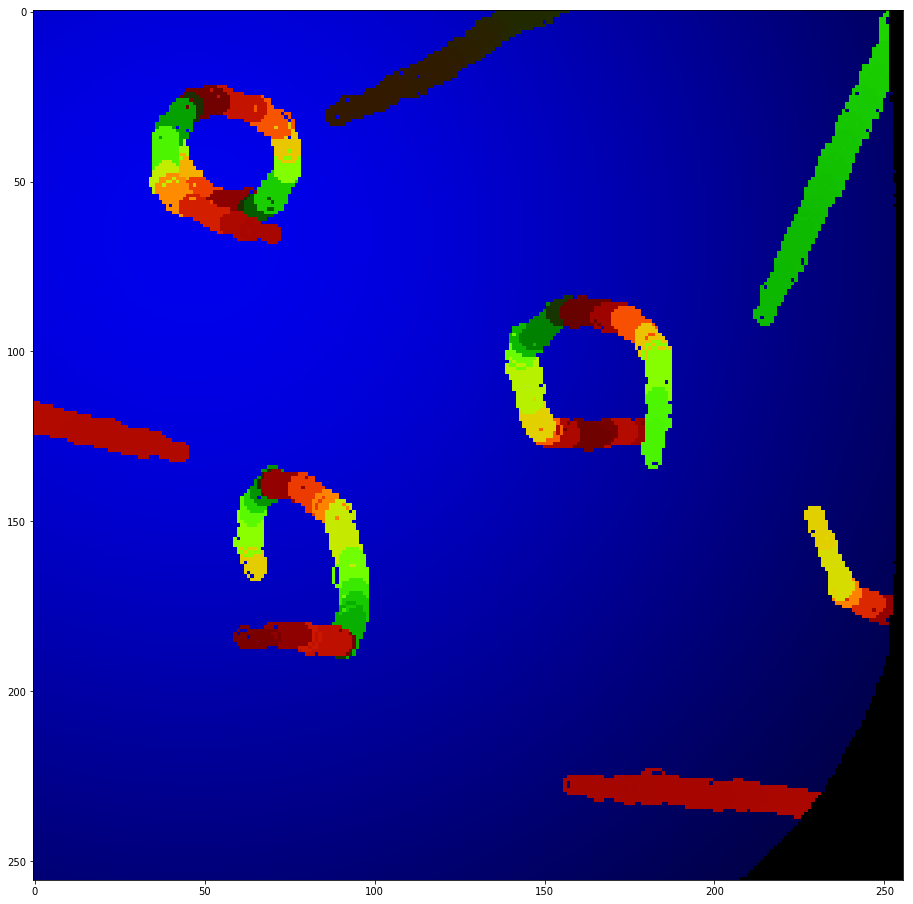

In [12]:
plt.figure(figsize=(16,16))
plt.imshow(create_syn_image(0),cmap='gray')
plt.show()

In [13]:
for i in range(num_samples):
    io.imsave(data_path+'Synthetic/'+str(i).zfill(4)+'.png',create_syn_image(i))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27